In [14]:
# Dimensionality Reduction Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings("ignore")

print("Starting Dimensionality Reduction Analysis...")


Starting Dimensionality Reduction Analysis...


In [15]:
# Load and prepare data
df = pd.read_csv("../training_data.csv")

# Handle missing values by treating zeros as NaN and dropping them
df["Total Renewable Energy"].replace(0, np.nan, inplace=True)
df.dropna(subset=["Total Renewable Energy"], inplace=True)

# Aggregate by Year and Quarter
df_agg = (
    df.groupby(["Year", "Quarter"])["Total Renewable Energy"]
    .sum()
    .reset_index()
    .sort_values(["Year", "Quarter"])
)

# Create datetime index
df_agg["Date"] = (
    pd.PeriodIndex(year=df_agg.Year, quarter=df_agg.Quarter, freq="Q")
    .to_timestamp()
)

# Feature engineering
for lag in range(1, 9):
    df_agg[f"lag_{lag}"] = df_agg["Total Renewable Energy"].shift(lag)

# Rolling statistics
df_agg["roll_mean_4"] = df_agg["Total Renewable Energy"].shift(1).rolling(4).mean()
df_agg["roll_std_4"] = df_agg["Total Renewable Energy"].shift(1).rolling(4).std()

# Drop NaN values
df_agg.dropna(inplace=True)
df_agg.reset_index(drop=True, inplace=True)

# Prepare features
feature_cols = [col for col in df_agg.columns if col.startswith('lag_') or col.startswith('roll_')]
X = df_agg[feature_cols]
y = df_agg["Total Renewable Energy"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Dataset shape: {X_scaled.shape}")
print(f"Features: {feature_cols}")


Dataset shape: (197, 10)
Features: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'roll_mean_4', 'roll_std_4']


In [16]:
# PCA Analysis
print("\n1. Principal Component Analysis (PCA)")
print("=" * 50)

# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Components needed for 95% variance: {n_components_95}")

# PCA with optimal components
pca_optimal = PCA(n_components=n_components_95)
X_pca_optimal = pca_optimal.fit_transform(X_scaled)

print(f"Original dimensions: {X_scaled.shape[1]}")
print(f"Reduced dimensions: {X_pca_optimal.shape[1]}")
print(f"Variance explained: {cumulative_variance[n_components_95-1]:.3f}")



1. Principal Component Analysis (PCA)
Components needed for 95% variance: 2
Original dimensions: 10
Reduced dimensions: 2
Variance explained: 0.978


In [17]:
# t-SNE Analysis with corrected parameter
print("\n2. t-SNE Analysis")
print("=" * 50)

# Test different perplexity values
perplexity_values = [5, 10, 30, 50]
tsne_results = {}

for i, perplexity in enumerate(perplexity_values):
    print(f"Computing t-SNE with perplexity={perplexity}...")
    
    # FIXED: Use max_iter instead of n_iter
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, 
                max_iter=1000, learning_rate=200)
    tsne_scores = tsne.fit_transform(X_scaled)
    
    tsne_results[f'perplexity_{perplexity}'] = {
        'model': tsne,
        'scores': tsne_scores,
        'perplexity': perplexity
    }
    
    print(f"✓ Completed t-SNE with perplexity={perplexity}")

print(f"t-SNE analysis completed for {len(perplexity_values)} perplexity values")



2. t-SNE Analysis
Computing t-SNE with perplexity=5...
✓ Completed t-SNE with perplexity=5
Computing t-SNE with perplexity=10...
✓ Completed t-SNE with perplexity=10
Computing t-SNE with perplexity=30...
✓ Completed t-SNE with perplexity=30
Computing t-SNE with perplexity=50...
✓ Completed t-SNE with perplexity=50
t-SNE analysis completed for 4 perplexity values



3. Visualization


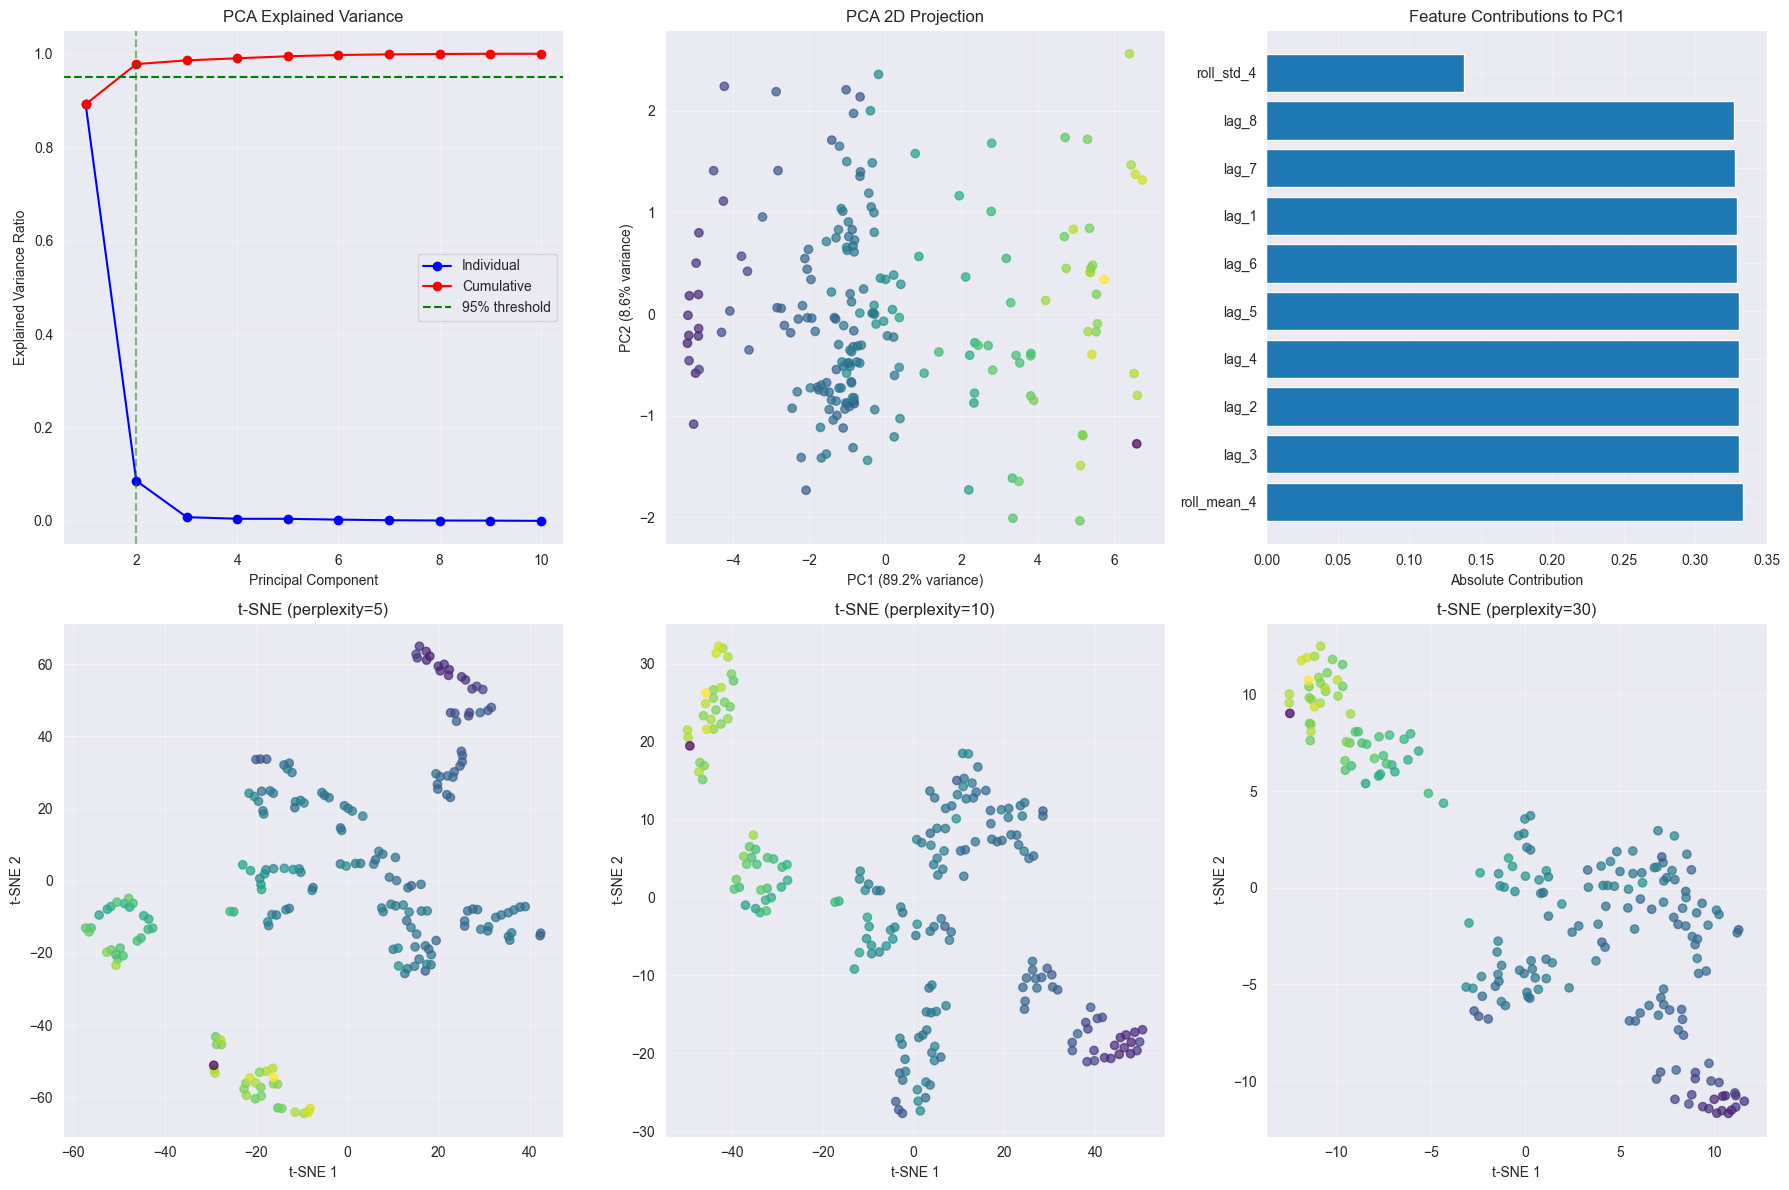

In [18]:
# Visualization
print("\n3. Visualization")
print("=" * 50)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: PCA Explained Variance
axes[0, 0].plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-', label='Individual')
axes[0, 0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-', label='Cumulative')
axes[0, 0].axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
axes[0, 0].axvline(x=n_components_95, color='g', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].set_title('PCA Explained Variance')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: PCA 2D projection
axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[0, 1].set_xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
axes[0, 1].set_ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
axes[0, 1].set_title('PCA 2D Projection')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Feature contributions to PC1
feature_contributions = np.abs(pca.components_[0])
sorted_indices = np.argsort(feature_contributions)[::-1]
axes[0, 2].barh(range(len(feature_contributions)), feature_contributions[sorted_indices])
axes[0, 2].set_yticks(range(len(feature_contributions)))
axes[0, 2].set_yticklabels([feature_cols[i] for i in sorted_indices])
axes[0, 2].set_xlabel('Absolute Contribution')
axes[0, 2].set_title('Feature Contributions to PC1')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4-6: t-SNE results with different perplexities
for i, (key, result) in enumerate(tsne_results.items()):
    row = 1
    col = i
    if col < 3:  # Only plot first 3 results
        scatter = axes[row, col].scatter(result['scores'][:, 0], result['scores'][:, 1], 
                                       c=y, cmap='viridis', alpha=0.7)
        axes[row, col].set_xlabel('t-SNE 1')
        axes[row, col].set_ylabel('t-SNE 2')
        axes[row, col].set_title(f't-SNE (perplexity={result["perplexity"]})')
        axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [19]:
# Comparison Analysis
print("\n4. Comparison Analysis")
print("=" * 50)

# Calculate reconstruction error for PCA
X_reconstructed = pca_optimal.inverse_transform(X_pca_optimal)
reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2)

print(f"PCA Results:")
print(f"- Original dimensions: {X_scaled.shape[1]}")
print(f"- Reduced dimensions: {X_pca_optimal.shape[1]}")
print(f"- Dimensionality reduction: {(1 - X_pca_optimal.shape[1]/X_scaled.shape[1])*100:.1f}%")
print(f"- Variance preserved: {cumulative_variance[n_components_95-1]*100:.1f}%")
print(f"- Reconstruction error: {reconstruction_error:.4f}")

print(f"\nt-SNE Results:")
for key, result in tsne_results.items():
    print(f"- {key}: 2D embedding created")

# Feature importance analysis
print(f"\nTop 5 most important features (PC1):")
top_features = [(feature_cols[i], feature_contributions[i]) for i in sorted_indices[:5]]
for feature, contribution in top_features:
    print(f"- {feature}: {contribution:.3f}")



4. Comparison Analysis
PCA Results:
- Original dimensions: 10
- Reduced dimensions: 2
- Dimensionality reduction: 80.0%
- Variance preserved: 97.8%
- Reconstruction error: 0.0221

t-SNE Results:
- perplexity_5: 2D embedding created
- perplexity_10: 2D embedding created
- perplexity_30: 2D embedding created
- perplexity_50: 2D embedding created

Top 5 most important features (PC1):
- roll_mean_4: 0.334
- lag_3: 0.331
- lag_2: 0.331
- lag_4: 0.331
- lag_5: 0.331


In [20]:
# 5. Save Results
print("\n5. Save Results")
print("=" * 50)

from pathlib import Path
import joblib, sklearn

# ensure models directory exists
models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

# Build the dimensionality-reduction bundle
dr_bundle = {
    # The estimator you call `.transform(...)` on
    "model": pca_optimal,

    # Exact raw columns you passed into PCA/UMAP/TSNE
    "features": feature_cols,

    # If you scaled before fitting, include the scaler here:
    "scaler": scaler,

    # So the dispatcher knows to skip per-task engineering
    "task": "dim_reduce",

    # Helpful metadata (optional)
    "n_components_95": n_components_95,
    "explained_variance": explained_variance,
    "reconstruction_error": reconstruction_error,

    # Your t-SNE “results” can live here if you want:
    "tsne_results": tsne_results,

    # Version pin
    "sklearn": sklearn.__version__,
}

# Write out the bundle
out_path = models_dir / "dimensionality_reduction.pkl"
joblib.dump(dr_bundle, out_path)
print(f"✓ Dimensionality-reduction bundle saved to {out_path}")

print("\nDimensionality Reduction Analysis Complete!")



5. Save Results
✓ Dimensionality-reduction bundle saved to ..\models\dimensionality_reduction.pkl

Dimensionality Reduction Analysis Complete!
